# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from catboost import CatBoostClassifier
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

Загрузим и изучим данные:  
   
*Признаки*
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  
  
*Целевой признак*  
- Price — цена (евро)

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датасете содержится информация о 354369 автомобилях, охарактеризованных по 16 признакам.

Проверим данные на наличие дубликатов:

In [5]:
data.duplicated().sum()

4

Есть 4 дубликата, удалим:

In [6]:
data = data.drop_duplicates().reset_index(drop=True)

Проверим данные на наличие пропусков.

In [7]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

5 столбцов содержат пропуски: тип кузова, тип коробки передач, модель автомобиля, тип топлива и показатель, была ли машина в ремонте.

Посмотрим, что можно сделать с пропусками в столбце 'VehicleType':

In [8]:
data['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [9]:
data['VehicleType'].isna().sum() / data['VehicleType'].count() * 100

11.831163708086786

Не представляется возможным предсказать, какие значения скрываются за пропусками в столбце "тип кузова". Однако, автомобили с пропусками в данном столбце занимают весомую часть датасета - более 10 %. Удаленине данных автомобилей не представляется целесообразным, заменим пропуски в данном столбце на 'unknown'.

In [10]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

Посмотрим, что можно сделать с пропусками в столбце 'Gearbox':

In [11]:
data['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

Подавляющее большинство машин в представленных данных - с ручной коробкой передач. Таким образом, пропуски в данном значке можно заменить преобладающим значением по столбцу - 'manual'.

In [12]:
data['Gearbox'] = data['Gearbox'].fillna('manual')

Посмотрим, как поступить с пропусками в столбце 'Model':

In [13]:
data['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [14]:
data['Model'].isna().sum() / data['Model'].count() * 100

5.888065499312735

В данных представлено большое разнообразие моделей. Не представляется возможным предсказать, какая модель скрывается за пропущенным значением. При этом представляется очевидным, что модель автомобиля сильно влияет на стоимость. Так как автомобили с пропуском в данном столбце составляют только около 6% от всего датасета, наиболее правильно будет удалить данные строки.

In [15]:
data = data.dropna(subset=['Model'])

Посмотрим, что можно сделать с пропусками в столбце 'FuelType':

In [16]:
data['FuelType'].value_counts()

petrol      207159
gasoline     95856
lpg           4962
cng            544
hybrid         208
other          133
electric        66
Name: FuelType, dtype: int64

Заполним пропуски преобладающим значением по столбцу:

In [17]:
data['FuelType'] = data['FuelType'].fillna('petrol')

Посмотрим на пропуски в столбце 'NotRepaired':

In [18]:
data['NotRepaired'].value_counts()

no     238852
yes     33708
Name: NotRepaired, dtype: int64

Заполним также преобладающим значением:

In [19]:
data['NotRepaired'] = data['NotRepaired'].fillna('no')

In [20]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Все дубликаты и пропуски удалены, типы данных соответствуют действительности. Первичная предобработка данных выполнена. Изучим данные на предмет аномальных значений.

In [21]:
data['RegistrationYear'].describe()

count    334660.000000
mean       2003.924024
std          69.377633
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

Самый ранний год регистрации автомобиля - 1000, самый поздний - 9999. В данном столбце явно присутствуют аномальные значения. Определим рамки реальных значений:

array([[<AxesSubplot:title={'center':'RegistrationYear'}>]], dtype=object)

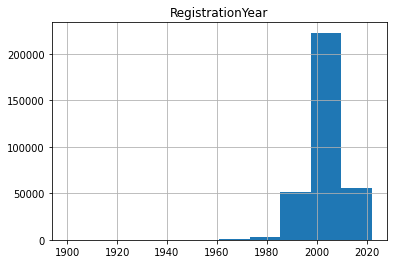

In [22]:
data.hist(column='RegistrationYear', bins=10, range=(1900, 2022))

In [23]:
data['DateCreated']

0         2016-03-24 00:00:00
2         2016-03-14 00:00:00
3         2016-03-17 00:00:00
4         2016-03-31 00:00:00
5         2016-04-04 00:00:00
                 ...         
354359    2016-03-27 00:00:00
354360    2016-03-21 00:00:00
354362    2016-03-05 00:00:00
354363    2016-03-19 00:00:00
354364    2016-03-20 00:00:00
Name: DateCreated, Length: 334660, dtype: object

Данные были выгружены в 2016 году. Оставим в датасете только автомобили, которые были зарегистрированы с 1960 по 2016 гг.

In [24]:
data = data.query('1960 <= RegistrationYear <= 2016').reset_index(drop=True)

In [25]:
data['Power'].describe()

count    321950.000000
mean        112.270005
std         182.023515
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

Максимальная мощность - 20000 л.с., минимальная - 0. Здесь также очевидно наличие аномальных значений. Определим рамки реальных значений:

array([[<AxesSubplot:title={'center':'Power'}>]], dtype=object)

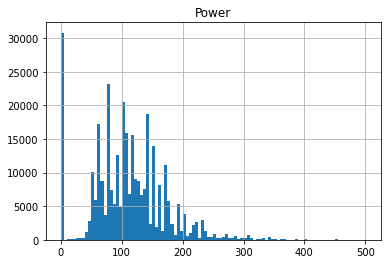

In [26]:
data.hist(column='Power', bins=100, range=(0, 500))

Оставим в датасете только автомобили, мощность двигателя которых находится в диапазоне от 50 до 300 л.с.:

In [27]:
data = data.query('50 <= Power <= 300').reset_index(drop=True)

In [28]:
data['Brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'lancia', 'citroen', 'toyota',
       'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'lada',
       'trabant'], dtype=object)

С марками автомобилей в датасете все в порядке, скрытых дубликатов нет.

In [29]:
data['NumberOfPictures'].describe()

count    283031.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Ни к одному автомобилю из датасета не прилагаются фотографии. Значит, это признак не понадобится для обучения модели.

In [30]:
data['Price'].describe()

count    283031.000000
mean       4792.518887
std        4577.135064
min           0.000000
25%        1300.000000
50%        3150.000000
75%        6950.000000
max       20000.000000
Name: Price, dtype: float64

По цене также содержатся аномальные значения и выбросы. Определим необходимые рамки:

array([[<AxesSubplot:title={'center':'Price'}>]], dtype=object)

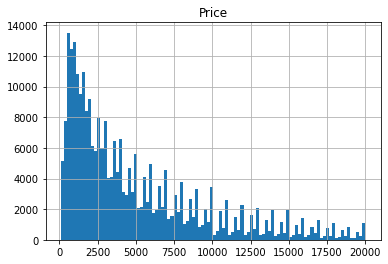

In [31]:
data.hist(column='Price', bins=100, range=(100, 20000))

Оставим автомобили стоимостью от 700 до 15000 евро:

In [32]:
data = data.query('700 <= Price <= 15000').reset_index(drop=True)

Данные обработаны, удалены аномальные значения и выбросы. Теперь посмотрим на зависимость цены от остальных признаков, чтобы определить, какие признаки нужно будет использовать для обучения модели.

In [33]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.506021,0.428183,-0.355524,0.044709,NaN,0.048172
RegistrationYear,0.506021,1.000000,0.033998,-0.327487,0.026969,NaN,0.013296
Power,0.428183,0.033998,1.000000,0.189927,0.022238,NaN,0.043188
Kilometer,-0.355524,-0.327487,0.189927,1.000000,-0.009835,NaN,-0.003310
RegistrationMonth,0.044709,0.026969,0.022238,-0.009835,1.000000,NaN,0.000054
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.048172,0.013296,0.043188,-0.003310,0.000054,NaN,1.000000


Оставим в данных следующие признаки для создания модели: VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, FuelType, Brand, NotRepaired, Price.

In [34]:
data_m = data[['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 
               'FuelType', 'Brand', 'NotRepaired', 'Price']]

Выделим признаки и целевой признак для построения модели:

In [35]:
features = data_m.drop('Price', axis=1)
target = data_m['Price']

Преобразуем категориальные признаки в численные двумя способами для разных моделей:

In [36]:
features_ohe = pd.get_dummies(features, drop_first=True)

encoder = OrdinalEncoder()
encoder.fit(features)
features_ordinal = encoder.transform(features)

Разобьем данные на обучающую, валидационную и тестовую выборки (для каждого типа кодировки и без нее):

In [37]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                             test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid,
                                                target_valid, test_size=0.5, random_state=12345)

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe, 
                                                            target, test_size=0.4, random_state=12345)
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(features_valid_ohe,
                                                target_valid_ohe, test_size=0.5, random_state=12345)

features_train_ordinal, features_valid_ordinal, target_train_ordinal, target_valid_ordinal = train_test_split(features_ordinal, 
                                                                        target, test_size=0.4, random_state=12345)
features_valid_ordinal, features_test_ordinal, target_valid_ordinal, target_test_ordinal = train_test_split(features_valid_ordinal,
                                                target_valid_ordinal, test_size=0.5, random_state=12345)

Масштабируем численные признаки:

In [38]:
scaler = StandardScaler()
scaler.fit(features_train_ohe)
features_train_ohe = scaler.transform(features_train_ohe)
features_valid_ohe = scaler.transform(features_valid_ohe)
features_test_ohe = scaler.transform(features_test_ohe)

Данные готовы. Можно приступать к обучению моделей.

## Обучение моделей

Создадим метрику для кросс-валидации:

In [39]:
def rmse(target, predicted):
    mse = mean_squared_error(target, predicted)
    return mse**0.5
rmse_scorer = make_scorer(rmse, greater_is_better=False)

**Построим модель линейной регрессии и проверим ее качество кроссвалидацией:**

In [40]:
%%time
model = LinearRegression()
score = cross_val_score(model, features_train_ohe, target_train_ohe, scoring=rmse_scorer, cv=5).mean()
print('rmse модели:', score)

rmse модели: -414244225388811.75
CPU times: user 37 s, sys: 17.1 s, total: 54.2 s
Wall time: 54.6 s

Модель линейной регрессии показала очень плохой результат.

Посмотрим, сколько времени понадобится на обучение такой модели и на предсказание:

In [41]:
%%time
LR = LinearRegression()
LR.fit(features_train_ohe, target_train_ohe)

In [42]:
%%time
lr_pred = LR.predict(features_valid_ohe)

Модели линейной регрессии понадобилось 12.3 s на обучение и 15.5 ms на предсказание.

**Построим модель древа решений и подберем наилучшие параметры:**

In [43]:
%%time
DTR = DecisionTreeRegressor(random_state=12345)
GSCV = GridSearchCV(DTR, {'max_depth': list(range(1, 10))}, cv=5, scoring=rmse_scorer)
GSCV.fit(features_train_ordinal, target_train_ordinal)
print('Лучшая глубина древа:', GSCV.best_estimator_)
print('rmse модели:', GSCV.best_score_)

Лучшая глубина древа: DecisionTreeRegressor(max_depth=9, random_state=12345)
rmse модели: -1740.2719265613832
CPU times: user 5.29 s, sys: 12.8 ms, total: 5.31 s
Wall time: 5.31 s

Посмотрим, сколько времени потребуется на обучение такой модели и на предсказание:

In [44]:
%%time
DTR = DecisionTreeRegressor(random_state=12345, max_depth=9)
DTR.fit(features_train_ordinal, target_train_ordinal)

In [45]:
%%time
dtr_pred = DTR.predict(features_valid_ordinal)

Модели древа решений с глубиной древа 9 понадобилось 230 ms на обучение и 5.08 ms на предсказание.

**Построим модель случайного леса и подберем наилучшие параметры:**

In [46]:
%%time
RFR = RandomForestRegressor(random_state=12345)
RSCV = RandomizedSearchCV(RFR, {'max_depth': list(range(1, 20)), 'n_estimators': list(range(1, 20))}, cv=5, scoring=rmse_scorer)
RSCV.fit(features_train_ordinal, target_train_ordinal)
print('Лучшие параметры случайного леса:', RSCV.best_params_)
print('rmse модели:', RSCV.best_score_)

Лучшие параметры случайного леса: {'n_estimators': 14, 'max_depth': 16}
rmse модели: -1417.3364903657844
CPU times: user 1min 18s, sys: 149 ms, total: 1min 19s
Wall time: 1min 19s

Посмотрим, сколько времени понадобится такой модели на обучение и предсказание:

In [47]:
%%time
RFR = RandomForestRegressor(random_state=12345, n_estimators=14, max_depth=16)
RFR.fit(features_train_ordinal, target_train_ordinal)

In [48]:
%%time
rfr_pred = RFR.predict(features_valid_ordinal)

Модели случайного леса с 14 деревьями и максимальной глубиной древа - 16 понадобилось 3.2 s на обучение и 126 ms на предсказание.

**Построим модель градиентного бустинга:**

In [49]:
%%time
gbm = lgb.LGBMRegressor(objective='regression')
score = cross_val_score(gbm, features_train_ordinal, target_train_ordinal, scoring=rmse_scorer, cv=5).mean()
print('rmse модели:', score)

rmse модели: -1440.9637238902528
CPU times: user 20.7 s, sys: 0 ns, total: 20.7 s
Wall time: 20.9 s

Посмотрим, сколько времени понадобится такой модели на обучение и предсказание:

In [50]:
%%time
GBM_no_params = lgb.LGBMRegressor(objective='regression')
GBM_no_params.fit(features_train_ordinal, target_train_ordinal)

In [51]:
%%time
GBM_no_params_pred = GBM_no_params.predict(features_valid_ordinal)

Модели градиентного бустинга без подобранных параметров понадобилось 4min 7s на обучение и 396 ms на предсказание.

**Построим модель градиентного бустинга и подберем наилучшие параметры:**

In [52]:
%%time
GBM = lgb.LGBMRegressor(objective='regression')
parameters = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}
GSCV = GridSearchCV(GBM, parameters, scoring=rmse_scorer)
GSCV.fit(features_train_ordinal, target_train_ordinal)
print('Лучшие параметры градиентного бустинга:', GSCV.best_estimator_)
print('rmse модели:', GSCV.best_score_)

Лучшие параметры градиентного бустинга: LGBMRegressor(learning_rate=1, n_estimators=40, objective='regression')
rmse модели: -1466.7145477671431
CPU times: user 44.8 s, sys: 142 ms, total: 44.9 s
Wall time: 45.4 s

Посмотрим, сколько времени понадобится такой модели на обучение и предсказание:

In [53]:
%%time
GBM_params = lgb.LGBMRegressor(learning_rate=1, n_estimators=40, objective='regression')
GBM_params.fit(features_train_ordinal, target_train_ordinal)

In [54]:
%%time
GBM_params.predict(features_valid_ordinal)

Модели градиентного бустинга со скоростью обучения 1 и количеством деревьев 40 понадобилось 1.61 s на обучение и 95.8 ms на предсказание.

## Анализ моделей

Сравним полученные модели:

In [55]:
models = pd.DataFrame({'model': ['Linear Regression (no params)', 
                                 'Decision Tree Regressor (max_depth=9)', 
                                 'Random Forest Regressor (n_est=14, max_depth=16)', 
                                 'LGBM Regressor (no params)', 
                                'LGBM Regressor (learning_rate=1, n_est=40)'], 
                       'learning time': ['12.3 s', '230 ms', '3.2 s', '4 min 7 s', '1.61 s'],
                       'prediction time' : ['15.5 ms', '5.08 ms', '126 ms', '396 ms', '95.8 ms'],
                       'rmse' : [414244225388812, 1740, 1417, 1441, 1467]})

In [56]:
models

,model,learning time,prediction time,rmse
0,Linear Regression (no params),12.3 s,15.5 ms,414244225388812
1,Decision Tree Regressor (max_depth=9),230 ms,5.08 ms,1740
2,"Random Forest Regressor (n_est=14, max_depth=16)",3.2 s,126 ms,1417
3,LGBM Regressor (no params),4 min 7 s,396 ms,1441
4,"LGBM Regressor (learning_rate=1, n_est=40)",1.61 s,95.8 ms,1467


Учитывая скорость обучения и полученное значение rmse можно выделить 2 модели: модель случайного леса с количеством деревьев 14 и максимальной глубиной древа 16 и модель градиентного бустинга со скоростью обучения 1 и количеством деревьев 40. Проверим данные модели на тестовой выборке:

In [57]:
RFR = RandomForestRegressor(random_state=12345, n_estimators=14, max_depth=16)
RFR.fit(features_train_ordinal, target_train_ordinal)
rfr_pred = RFR.predict(features_test_ordinal)
rfr_rmse = rmse(target_test_ordinal, rfr_pred)
print(rfr_rmse)

1392.3878375352242


In [58]:
GBM_params = lgb.LGBMRegressor(learning_rate=1, n_estimators=40, objective='regression')
GBM_params.fit(features_train_ordinal, target_train_ordinal)
gbm_pred = GBM_params.predict(features_test_ordinal)
gbm_rmse = rmse(target_test_ordinal, gbm_pred)
print(gbm_rmse)

1450.0328911635058


Лучшее значение на тесте показала модель случайного леса с количеством деревьев 14 и максимальной глубиной древа 16.